In [31]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
import matplotlib.pyplot as plt
import elk
import torch as t
import os
import pandas as pd
import numpy as np
import transformers
from transformers import AutoModelForMaskedLM, AutoTokenizer
from elk.extraction.prompt_dataset import PromptDataset, PromptConfig
from elk.extraction.extraction import ExtractionConfig, extract_hiddens, extract
import yaml

from elk.utils.results import (
    RPATH,
    load_config,
    get_relevant_runs,
    get_eval,
    graph_eval,
    get_reporters,
    reporter_outputs,
    reporter_output,
    plot_2d_tensor_as_heatmap,
    best_layer_num,
    best_reporter,
    best_layer_output,
    dsget
)

In [33]:
device = "cuda"

In [34]:
model_name = "microsoft/deberta-v2-xxlarge-mnli"
dataset_name = "ag_news"
model = AutoModelForMaskedLM.from_pretrained(model_name).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of the model checkpoint at microsoft/deberta-v2-xxlarge-mnli were not used when initializing DebertaV2ForMaskedLM: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing DebertaV2ForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DebertaV2ForMaskedLM were not initialized from the model checkpoint at microsoft/deberta-v2-xxlarge-mnli and are newly initialized: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
You should 

In [35]:
prompt_config = PromptConfig(dataset_name)
dataset = PromptDataset(prompt_config, split="train")

Found cached dataset ag_news (/fsx/home-rudolf/hf_data_cache/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548)
100%|██████████| 2/2 [00:00<00:00,  7.10it/s]
Loading cached shuffled indices for dataset at /fsx/home-rudolf/hf_data_cache/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548/cache-dd0ff9596fea92b0.arrow


In [36]:
s = set()
for i in range(len(dataset)):
    s.add(dataset[i][0].label)

In [37]:
s

{0, 1}

In [65]:
dsget(dataset, 0)

('What label best describes this news article?\nBangladesh paralysed by strikes Opposition activists have brought many towns and cities in Bangladesh to a halt, the day after 18 people died in explosions at a political rally.\nWorld politics',
 'What label best describes this news article?\nBangladesh paralysed by strikes Opposition activists have brought many towns and cities in Bangladesh to a halt, the day after 18 people died in explosions at a political rally.\nBusiness')

In [66]:
RPATH = "/fsx/home-rudolf/elk-reporters"

In [67]:
runs = get_relevant_runs(
    {
        "data.prompts.dataset": dataset_name,
        "net.net_name": "eigen",
        "data.model": model_name
    }
)

In [68]:
runs

['infallible-brown', 'priceless-bouman']

In [69]:
run = runs[-1]

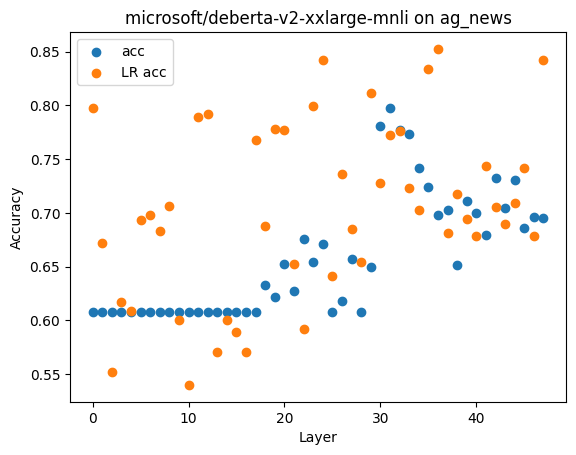

In [70]:
graph_eval(run)

In [71]:
# reporters = get_reporters(run)

In [72]:
# reporters[0]

In [73]:
tokens = tokenizer("This is a test", return_tensors="pt").input_ids.to(device)

In [74]:
outo = model(tokens, output_hidden_states=True)

In [75]:
len(outo[1])

49

In [76]:
get_eval(run)

,layer,pseudo_auroc,train_loss,acc,cal_acc,auroc,ece,lr_auroc,lr_acc
0,0,0.5,-2.0085,0.6080,0.5776,0.5479,0.3901,0.8758,0.7976
1,1,0.5,-0.0035,0.6080,0.5621,0.5409,0.3906,0.7443,0.6720
2,2,0.5,-0.0001,0.6080,0.5408,0.5774,0.5862,0.5747,0.5517
3,3,0.5,-0.0004,0.6080,0.5216,0.5595,0.5857,0.6627,0.6175
4,4,0.5,-0.0001,0.6080,0.5211,0.5631,0.5749,0.6351,0.6083
5,5,0.5,-0.0009,0.6080,0.5088,0.5506,0.5858,0.7618,0.6933
6,6,0.5,-0.0005,0.6080,0.5243,0.5737,0.5746,0.7600,0.6976
7,7,0.5,-0.0002,0.6080,0.5685,0.5381,0.3912,0.7353,0.6833
8,8,0.5,-0.0016,0.6080,0.5205,0.5699,0.5740,0.7739,0.7068
9,9,0.5,-0.0001,0.6080,0.5243,0.5655,0.5859,0.6306,0.6008


In [77]:
best_layer_num(run)

31

In [82]:
best_layer_output(model, tokenizer, run, "Is 1+1=2? Yes")

tensor([  56.1649,  324.6794,   33.7451,   32.6317,   95.2264, -145.0999,
         -32.0354,  233.5305,  -53.6458], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [83]:
best_layer_output(model, tokenizer, run, "Is 1+1=2? No")

tensor([  49.5355,  315.6525,   37.0467,   32.9943,   94.9747, -146.2065,
          -8.9162,  234.6954,  -36.3168], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [80]:
# plot_2d_tensor_as_heatmap(reporter_outputs(reporters, "Is 1 + 1 = 2? No"))

## Sanity test for reporter - using existing code

In [88]:
best_layer_num(run)

31

In [89]:
load_config(run)

{'data': {'layers': [],
  'model': 'microsoft/deberta-v2-xxlarge-mnli',
  'prompts': {'balance': False,
   'data_dir': None,
   'dataset': 'ag_news',
   'label_column': None,
   'max_examples': [750, 250],
   'num_classes': None,
   'num_shots': 0,
   'num_variants': -1,
   'seed': 42},
  'token_loc': 'last'},
 'debug': False,
 'max_gpus': -1,
 'net': {'inv_weight': 5.0,
  'neg_cov_weight': 5.0,
  'net_name': 'eigen',
  'num_heads': 1,
  'seed': 999,
  'var_weight': 1.0},
 'normalization': 'meanonly',
 'optim': {'lr': 0.01,
  'num_epochs': 1000,
  'num_tries': 10,
  'optimizer': 'lbfgs',
  'weight_decay': 0.01},
 'skip_baseline': False}

In [84]:
from elk.evaluation.evaluate import (
    evaluate_reporter,
    EvaluateConfig,
    evaluate_reporters
)

prompt_config2 = PromptConfig(dataset_name)
eval_config = EvaluateConfig(
    ExtractionConfig(prompt_config2, model_name),
    run,
    max_gpus=1
)



In [90]:
ds = extract(eval_config)

AttributeError: 'EvaluateConfig' object has no attribute 'model'

In [85]:
eval_config.target

ExtractionConfig(prompts=PromptConfig(dataset='ag_news', balance=False, data_dir=None, label_column=None, num_classes=None, max_examples=[750, 250], num_shots=0, num_variants=-1, seed=42), model='microsoft/deberta-v2-xxlarge-mnli', layers=(), token_loc='last')

In [ ]:
evaluate_reporters(
    eval_config,
    dataset,
    45,
    devices=[0]
)

AttributeError: 'PromptDataset' object has no attribute 'formatted_as'

## Sanity test for reporter - manually running reporter on arbitrary sentence

In [ ]:
def contrast_pair_activations(reporter, dataset, num_examples=10):    
    true_activations = []
    false_activations = []
    for i in range(num_examples):
        (true, false) = dsget(dataset, i)
        true_activations.append(reporter_output(reporter, true).cpu().detach().numpy())
        false_activations.append(reporter_output(reporter, false).cpu().detach().numpy())
    return (true_activations, false_activations)

def ccs_pair_stats(reporter, dataset, num_examples=10):
    true_acts, false_acts = contrast_pair_activations(reporter, dataset, num_examples)
    true_avgs = sum([np.mean(x) for x in true_acts]) / len(true_acts)
    false_avgs = sum([np.mean(x) for x in false_acts]) / len(false_acts)
    true_i_avgs = []
    false_i_avgs = []
    avg_diffs = []
    for i in range(5):
        true_tokens = np.array([x[-i] for x in true_acts])
        false_tokens = np.array([x[-i] for x in false_acts])
        true_i_avgs.append(true_tokens.sum() / true_tokens.shape[0])
        false_i_avgs.append(false_tokens.sum() / false_tokens.shape[0])
        avg_diffs.append((true_tokens - false_tokens).mean())
    return {
        "all": {
            "true_avg": true_avgs,
            "false_avg": false_avgs
        },
        "last_tokens" : {
            i : {
                "true_avg": true_i_avgs[i],
                "false_avg": false_i_avgs[i],
                "avg_diff": avg_diffs[i]
            } for i in range(len(true_i_avgs))
        }
    }

def plot_ccs_pairs(reporter, dataset, num_examples=10):
    true_activations, false_activations = contrast_pair_activations(reporter, dataset, num_examples)
    fig, ax = plt.subplots()
    for x in true_activations:
        ax.scatter(np.linspace(0, 1, x.shape[0]), x, color="green", alpha=0.2)
    for x in false_activations:
        ax.scatter(np.linspace(0, 1, x.shape[0]), x, color="red", alpha=0.2)
    fig.show()

In [ ]:
ccs_pair_stats(best_reporter(run), dataset, num_examples=100)

{'all': {'true_avg': 56.80379832625389, 'false_avg': 56.47858673870564},
 'last_tokens': {0: {'true_avg': 31.5162646484375,
   'false_avg': 31.36864990234375,
   'avg_diff': 0.1476122},
  1: {'true_avg': -67.3269970703125,
   'false_avg': -70.7493017578125,
   'avg_diff': 3.4223},
  2: {'true_avg': 63.3790966796875,
   'false_avg': 87.57171875,
   'avg_diff': -24.192621},
  3: {'true_avg': 73.75615234375,
   'false_avg': 89.436142578125,
   'avg_diff': -15.679998},
  4: {'true_avg': 65.9326708984375,
   'false_avg': 35.6895849609375,
   'avg_diff': 30.24308}}}

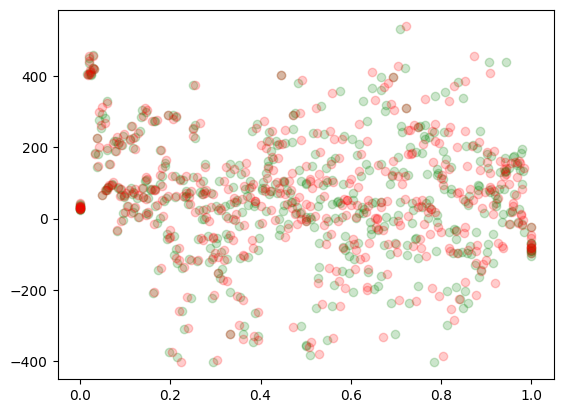

: 

In [ ]:
plot_ccs_pairs(best_reporter(run), dataset)